Test optimal transport 

#Exemple simple entre deux distributions discrètes

In [5]:
import numpy as np
import ot
import matplotlib.pyplot as plt
from scipy.stats import norm

In [11]:
# Source : N(0,1), Target : N(3,1)
n = 100
x1= np.linspace(-5, 5, n).reshape((n, 1))
x2 = np.linspace(-2, 8, n).reshape((n, 1))

a = norm.pdf(x1.flatten(), loc=0, scale=1) # densité (poids des différents poids dans le cadre continu)
b = norm.pdf(x2.flatten(), loc=3, scale=1)

a /= a.sum()
b /= b.sum() #correspond à normalisation des poids


In [13]:
#distance matrix

# Euclidienne (simple)
C = ot.dist(x1, x2)
C /= C.max()

In [16]:
# Solve transport problem
G1 = ot.emd2(a, b, C)# emd2 donne la Optimal transportation loss = mobilité dans notre cas alors que emd done le paln de transport
G2 = ot.emd(a,b,C) #spécifique aux distributions discrètes donc peu pertient dans notre cadre

#entropic regularization optimal transport

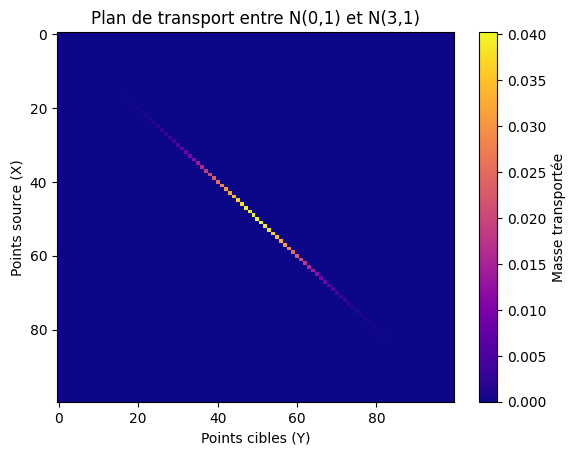

0.05325443786982245


In [17]:
# Visualisation du plan de transport
plt.imshow(G2, aspect='auto', cmap='plasma')
plt.title("Plan de transport entre N(0,1) et N(3,1)")
plt.xlabel("Points cibles (Y)")
plt.ylabel("Points source (X)")
plt.colorbar(label='Masse transportée')
plt.show()
print(G1)

In [12]:
#Ajout de varaibles auxiliaires 


z1 = np.linspace(-4, 4, n).reshape((n, 1))
z2= np.linspace(0, 8, n).reshape((n, 1))

# Calcul de la matrice de coût étendue, prenant en compte la variable auxiliaire (on additionne les couts avdc une valeur lambda arbitraire)
lambda_aux = 0.1  # Poids de l'importance de la variable auxiliaire
C_main = ot.dist(x1, x2)  # Distance entre les variables principales
C_aux = ot.dist(z1, z2)  # Distance entre les variables auxiliaires
C_extended = C_main + lambda_aux * C_aux  # Matrice de coût étendue

Inspiration de Galichon Linear programming : méthode Gurobi

In [ ]:
#matrices de contraintes (égalité des masses int_pix=mu(x))

In [40]:
import gurobipy as gp
from gurobipy import GRB,Model
import numpy as np
import scipy.sparse as sp
from scipy.optimize import linprog

In [59]:
# Distributions de salaires à t (source) et à t+1 (cible)
p = np.array([0.3, 0.4, 0.3])  # Distribution source (salaires à t)
q = np.array([0.5, 0.2, 0.3])  # Distribution cible (salaires à t+1)
d = np.concatenate([p, q])# Construit le vecteur d’équilibrage des masses

# Normaliser les distributions 
p /= p.sum()
q /= q.sum()


N=3 #dimension de p (3 points)
M=3 #dimension de q (3 points)

# Calculer la matrice de coût (ici, la distance absolue entre les salaires)
salaires_t = np.array([10, 20, 30])  # Exemple de salaires à t
salaires_t1 = np.array([15, 25, 35])  # Exemple de salaires à t+1
Phi= np.abs(np.subtract.outer(salaires_t, salaires_t1))  # Distance absolue




#matrice de contraintes (conservation de masse de source et masse cible)
A2 = sp.kron(np.ones((1, M)), sp.eye(N))#sommes des pi_i,j sur q = pi

A1= sp.kron(sp.eye(M), np.ones((1, N)))#somme des pi_i,j sur p = qj
A = sp.vstack([A1, A2]) #on construit matrice globale de contraintes

print(A1.shape)
print(A2.shape)
print(A.shape)

(3, 9)
(3, 9)
(6, 9)


In [60]:
# Résolution du problème avec Gurobi
m = Model()
x = m.addMVar(A.shape[1], lb=0, name="x") #poids de transports pour chque variables
# Ajouter la contrainte d'équilibre de masse
m.addConstr(A @ x == d)
# Fonction objectif : minimisation du coût de transport
m.setObjective(Phi.flatten() @ x, GRB.MINIMIZE)
# Résoudre le problème
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[rosetta2] - Darwin 23.6.0 23H420)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 6 rows, 9 columns and 18 nonzeros
Model fingerprint: 0x1b16d0d9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e-01]
Presolve time: 0.00s
Presolved: 6 rows, 9 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+00   4.000000e-01   0.000000e+00      0s
       1    5.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.000000000e+00


In [61]:
# Récupérer les résultats
if m.status == GRB.OPTIMAL:
    pi = x.X.reshape((N, M))  # Plan de transport optimal
    u = m.pi[:N]  # Potentiels pour X
    v = m.pi[N:]  # Potentiels pour Y
    val = m.objVal  # Valeur optimale de l'objectif
    print(f"Valeur de l'objectif (Gurobi) = {val}")
    print(f"u[0:10] = {u[:10]}")
    print(f"v[0:10] = {v[:10]}")
    
print(pi)

Valeur de l'objectif (Gurobi) = 5.0
u[0:10] = [5.0, 5.0, 5.0]
v[0:10] = [-0.0, 0.0, -0.0]
[[0.3 0.  0. ]
 [0.2 0.2 0. ]
 [0.  0.  0.3]]


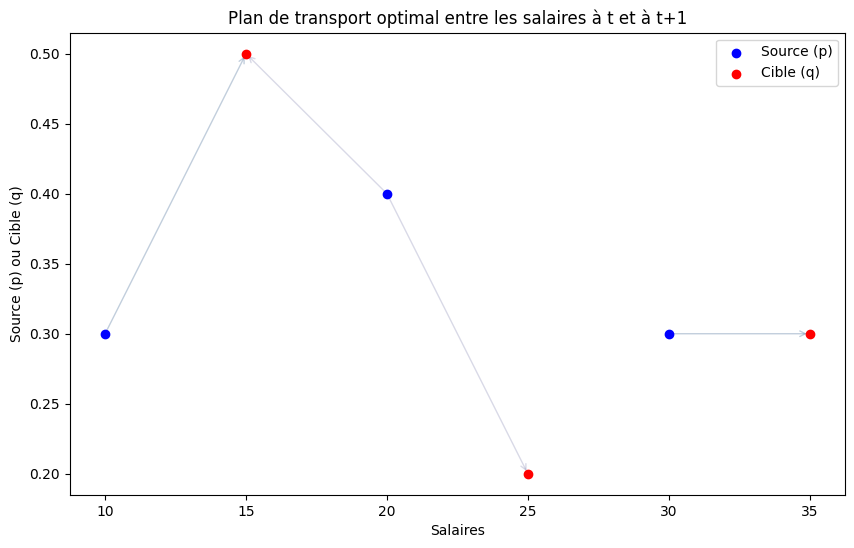

In [63]:
#visualisation 

# Visualiser les distributions et le plan de transport
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(salaires_t, p, c='blue', label='Source (p)', zorder=5)
ax.scatter(salaires_t1, q, c='red', label='Cible (q)', zorder=5)

for i in range(len(p)):
    for j in range(len(q)):
        if pi[i, j] > 0:  # Si la masse est transportée
            alpha = pi[i, j]  # La transparence ou l'intensité de la couleur est proportionnelle à pi[i, j]
            color = plt.cm.viridis(alpha)  # Utilisation de la colormap viridis pour la couleur
            
            # Dessin de la flèche
            ax.annotate('', xy=(salaires_t1[j], q[j]), xytext=(salaires_t[i], p[i]),
                        arrowprops=dict(facecolor=color, edgecolor=color, alpha=alpha, arrowstyle='->', lw=1))


ax.set_xlabel("Salaires")
ax.set_ylabel("Source (p) ou Cible (q)")
ax.legend()
plt.title("Plan de transport optimal entre les salaires à t et à t+1")
plt.show()
